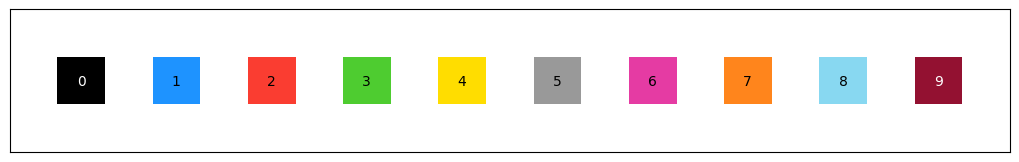

In [1]:
import sys
import json
import shutil
sys.path.append("../inputs/google-code-golf-2025/code_golf_utils")
from code_golf_utils import *
show_legend()

In [2]:
def get_examples(task_num):
    examples = load_examples(task_num)
    show_examples(examples['train'] + examples['test'])
    return examples

def save_file(task_num, sub_dir="/kaggle/working/submission/"):
    task_path = os.path.join(sub_dir, f"task{task_num:03d}.py")
    os.makedirs(sub_dir, exist_ok=True)
    shutil.copy("task.py", task_path)
    
def show_grid(out_grid, in_grid, ans_grid, figsize=(12, 4), k=-0.11):
    # Colors for each index
    colors = [
        (0, 0, 0),
        (30, 147, 255),
        (250, 61, 49),
        (78, 204, 48),
        (255, 221, 0),
        (153, 153, 153),
        (229, 59, 163),
        (255, 133, 28),
        (136, 216, 241),
        (147, 17, 49),
    ]
    colors = [(r/255, g/255, b/255) for r, g, b in colors]

    def plot_ax(ax, arr):
        rows = len(arr)
        cols = len(arr[0])
        # Draw each cell
        for y in range(rows):
            for x in range(cols):
                color = colors[arr[y][x]]
                rect = plt.Rectangle((x, y), 1, 1, facecolor=color, edgecolor="white")
                ax.add_patch(rect)

        # Axis limits
        ax.set_xlim(0, cols)
        ax.set_ylim(0, rows)
        # Center ticks in each cell
        ax.set_xticks([i + 0.5 for i in range(cols)])
        ax.set_yticks([i + 0.5 for i in range(rows)])
        # Label ticks as integers
        ax.set_xticklabels(range(cols))
        ax.set_yticklabels(range(rows))
        ax.tick_params(axis='both', length=0)
        # Move x-axis labels to top
        ax.xaxis.tick_top()
        ax.xaxis.set_label_position('top')
        # Invert y-axis so 0 is at the top
        ax.invert_yaxis()
        # Square cells
        ax.set_aspect('equal')

    fig, ax = plt.subplots(1, 3, figsize=figsize)
    plot_ax(ax[0],out_grid)
    ax[0].set_title("Output",y=k)
    plot_ax(ax[1], in_grid)
    ax[1].set_title("Input",y=k)
    plot_ax(ax[2],ans_grid)
    ax[2].set_title("Answer",y=k)
    plt.show()

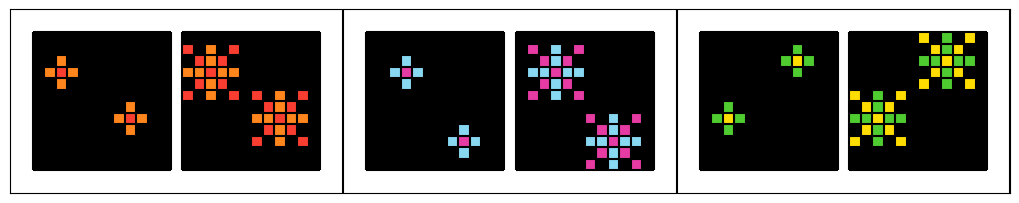

In [3]:
task_num = 12
examples = get_examples(task_num)

In [4]:
def p(g):
    """
    Transform 3x3 patterns in a 12x12 grid to 5x5 patterns.
    
    The transformation rule:
    - Find 3x3 patterns with a cross shape (center + 4 adjacent cells)
    - Convert them to 5x5 patterns using a specific expansion rule
    
    Pattern:
    Input 3x3:     Output 5x5:
    [0,A,0]        [B,0,A,0,B]
    [A,B,A]   ->   [0,B,A,B,0] 
    [0,A,0]        [A,A,B,A,A]
                   [0,B,A,B,0]
                   [B,0,A,0,B]
    
    Where A and B are the two different non-zero colors in the pattern.
    """
    
    # Create a copy of the input grid to modify
    result = [row[:] for row in g]
    
    # Search for 3x3 cross patterns in the grid
    for center_row in range(1, 11):  # Can't be on edges for 3x3 pattern
        for center_col in range(1, 11):
            
            # Check if this position is the center of a 3x3 cross pattern
            center_val = g[center_row][center_col]
            
            # Skip if center is 0 (background)
            if center_val == 0:
                continue
                
            # Check if we have a cross pattern (center + 4 adjacent non-zero values)
            top = g[center_row - 1][center_col]
            bottom = g[center_row + 1][center_col] 
            left = g[center_row][center_col - 1]
            right = g[center_row][center_col + 1]
            
            # Check corners should be 0 (background) for cross pattern
            top_left = g[center_row - 1][center_col - 1]
            top_right = g[center_row - 1][center_col + 1] 
            bottom_left = g[center_row + 1][center_col - 1]
            bottom_right = g[center_row + 1][center_col + 1]
            
            # Verify this is a cross pattern: center and 4 adjacent are non-zero, corners are zero
            if (top != 0 and bottom != 0 and left != 0 and right != 0 and
                top_left == 0 and top_right == 0 and bottom_left == 0 and bottom_right == 0 and
                top == bottom == left == right):  # All arms of cross are same color
                
                # Found a valid 3x3 cross pattern
                arm_color = top  # Color of the cross arms
                center_color = center_val  # Color of the center
                
                # Generate the 5x5 expansion pattern
                # Pattern positions relative to center:
                pattern_5x5 = [
                    [-2, -1,  0,  1,  2],  # row offsets
                    [-2, -1,  0,  1,  2]   # col offsets  
                ]
                
                # Define the 5x5 pattern based on the transformation rule
                # [B,0,A,0,B]
                # [0,B,A,B,0] 
                # [A,A,B,A,A]
                # [0,B,A,B,0]
                # [B,0,A,0,B]
                
                expansion_pattern = [
                    [center_color, 0, arm_color, 0, center_color],
                    [0, center_color, arm_color, center_color, 0],
                    [arm_color, arm_color, center_color, arm_color, arm_color],
                    [0, center_color, arm_color, center_color, 0],
                    [center_color, 0, arm_color, 0, center_color]
                ]
                
                # Apply the 5x5 pattern to the result grid
                for dr in range(-2, 3):  # -2 to 2 inclusive
                    for dc in range(-2, 3):  # -2 to 2 inclusive
                        new_row = center_row + dr
                        new_col = center_col + dc
                        
                        # Check bounds
                        if 0 <= new_row < 12 and 0 <= new_col < 12:
                            pattern_row = dr + 2  # Convert to 0-4 range
                            pattern_col = dc + 2  # Convert to 0-4 range
                            result[new_row][new_col] = expansion_pattern[pattern_row][pattern_col]
    
    return result

In [8]:
def p(g):
 r=[R[:]for R in g]
 for i in range(1,11):
  for j in range(1,11):
   c,t,b,l,R=g[i][j],g[i-1][j],g[i+1][j],g[i][j-1],g[i][j+1]
   if c*t*b*l*R*(t==b==l==R)*all(g[i+x][j+y]<1for x,y in[(-1,-1),(-1,1),(1,-1),(1,1)]):
    for x in range(5):
     for y in range(5):
      if-1<i+x-2<12>j+y-2>-1:r[i+x-2][j+y-2]=[[c,0,t,0,c],[0,c,t,c,0],[t,t,c,t,t],[0,c,t,c,0],[c,0,t,0,c]][x][y]
 return r

In [9]:
with open("../inputs/google-code-golf-2025/task012.json", "r", encoding="utf-8") as f:
  task_data = json.load(f)

example = task_data["train"][0]
input_grid = example["input"]
expected_output = example["output"]
actual_output = p(input_grid)

is_correct = actual_output == expected_output
status = "✓ 成功" if is_correct else "✗ 失敗"

print(input_grid)
print(expected_output)
print(actual_output)
print(status)

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 7, 2, 7, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 7, 2, 7, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 7, 0, 2, 0, 0, 0, 0, 0, 0, 0], [0, 2, 7, 2, 0, 0, 0, 0, 0, 0, 0, 0], [7, 7, 2, 7, 7, 0, 0, 0, 0, 0, 0, 0], [0, 2, 7, 2, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 7, 0, 2, 0, 2, 0, 7, 0, 2, 0], [0, 0, 0, 0, 0, 0, 0, 2, 7, 2, 0, 0], [0, 0, 0, 0, 0, 0, 7, 7, 2, 7, 7, 0], [0, 0, 0, 0, 0, 0, 0, 2, 7, 2, 0, 0], [0, 0, 0, 0, 0, 0, 2, 0, 7, 0, 2, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 7, 0, 2, 0, 0, 0, 0, 0, 0, 0], [0, 2, 7,

In [10]:
def test_json():
  with open("../inputs/google-code-golf-2025/task012.json", "r", encoding="utf-8") as f:
    task_data = json.load(f)
  
  train_success = 0
  for i, example in enumerate(task_data["train"]):
      input_grid = example["input"]
      expected_output = example["output"]
      actual_output = p(input_grid)
      
      is_correct = actual_output == expected_output
      status = "✓ 成功" if is_correct else "✗ 失敗"
      
      print(f"Train例{i+1}: {status}")
      if is_correct:
          train_success += 1

  print(f"訓練データの成功率: {train_success}/{len(task_data['train'])}")

  test_success = 0
  for i, example in enumerate(task_data["test"]):
      input_grid = example["input"]
      expected_output = example["output"]
      actual_output = p(input_grid)
      
      is_correct = actual_output == expected_output
      status = "✓ 成功" if is_correct else "✗ 失敗"
      
      print(f"Test例{i+1}: {status}")
      if is_correct:
          test_success += 1

  print(f"テストデータの成功率: {test_success}/{len(task_data['test'])}")

In [11]:
test_json()

Train例1: ✓ 成功
Train例2: ✓ 成功
訓練データの成功率: 2/2
Test例1: ✓ 成功
テストデータの成功率: 1/1
